# VC-dimension of neural networks

A neural network with $N$ weights and $L$ layers has VC-dimension $\mathcal O(NL \log(NL))$ (with a lower bound of $\Omega(NL\log(N/L))$.

Let's try to see that VC-dimension indeed grows linearly with $N$. How could we experimentally measure VC-dimension? Clearly, it's infeasible to actually check whether a given set is shattered -- for that we'd need to check exponentially many class assignments. Rather, I'd argue that if a neural network can fit random noise on a dataset of size $d$ then that's an indication that neural networks (with that set of parameters) can also shatter a set of that size. Thus, the strategy is as follows: given a number of neurons, search for the largest dataset size on which random noise can be perfectly fit. Because training can take very long until we reach perfect fit (if at all), I will say that the training set is *perfectly* fit if the accuracy is at least $95\%$. (Obviously, this is arbitrary and could as easily be set to $99\%$.)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
print("Tensorflow version: "+tf.version.VERSION)

Tensorflow version: 2.7.0


We generate a training set of pure random noise: 1000 datapoints with each 10 random features with values in $[0,1]$, with random binary classes.

In [2]:
num_features=10
train_size=1000
X=np.random.random((train_size,num_features))
y=np.random.randint(0,2,train_size)

The neural network will be a simple one, with one hidden layer with varying number of neurons. Because we have two classes the network has two output neurons. 

In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def set_up_model(num_hidden):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(num_features,)),
      tf.keras.layers.Dense(num_hidden, activation='relu'),
      tf.keras.layers.Dense(2)
    ])
    model.compile(loss=loss_fn, metrics=['accuracy'])    
    return model

We train each neural network for a given size of the training set up to 1000 epochs. If the necessary accuracy is reached earlier, we stop earlier. As we're just interested in whether the network can fit the noise data or not, it is not necessary to train the network beyond $95\%$ accuracy.

In [5]:
def run_model(model,size_of_data,max_epochs=1000,epochs_per_step=50):
    epochs_run=0
    accuracy=0
    while epochs_run<max_epochs and accuracy<threshold:
        model.fit(X[:size_of_data],y[:size_of_data],epochs=epochs_per_step,verbose=0)
        _,accuracy=model.evaluate(X[:size_of_data],y[:size_of_data],verbose=0)
        epochs_run+=epochs_per_step
    return accuracy    

For each network size we do a binary search for the largest dataset size it may fit. To save computing time, and because our precision is limited anyway, we stop if the optimal dataset size is narrowed to a sufficiently small interval (governed by 'gap').

In [6]:
def det_noise_fit_size(num_hidden,upper,lower):
    while upper-lower>gap:
        size=int(0.5*(upper+lower))
        model=set_up_model(num_hidden)
        acc=run_model(model,size)
        if acc>threshold:
            lower=size
        else:
            upper=size  
    return 0.5*(lower+upper)

One final issue: training a neural network is not deterministic. Sometimes, training works better, larger accuracy is reached, and sometimes it works worse. Because of that we repeat a certain number of times for each set of parameters. (At the moment the number of repeats is set to 3, which is certainly too low.)

In [7]:
gap=10
upper=200  # we assume that no network can fit a dataset of larger size -- this seems quite safe.
lower=10   # we assume that each of our networks can fit at least this size
threshold=0.95
repeats=5
network_sizes=np.arange(10,51,5)
fit_sizes=np.zeros((len(network_sizes),repeats))

# this will take a while...
for i,num_hidden in enumerate(network_sizes):
    print("network size: {}".format(num_hidden))
    for j in range(repeats):
        fit_size=det_noise_fit_size(num_hidden,upper,lower)
        fit_sizes[i,j]=fit_size

network size: 10
network size: 15
network size: 20
network size: 25
network size: 30
network size: 35
network size: 40
network size: 45
network size: 50


In [8]:
fit_sizes

array([[ 30. ,  30. ,  30. ,  30. ,  30. ],
       [ 30. ,  30. ,  30. ,  30. ,  30. ],
       [ 30. ,  96. ,  30. ,  90. ,  30. ],
       [ 90. ,  84. , 107.5,  96. ,  96. ],
       [102. , 131. ,  96. ,  60. ,  30. ],
       [113. , 155. , 179. , 125. , 155. ],
       [102. , 102. , 143. , 149. , 155. ],
       [161. , 173. , 191. , 185. , 179. ],
       [191. , 191. , 173. , 191. , 179. ]])

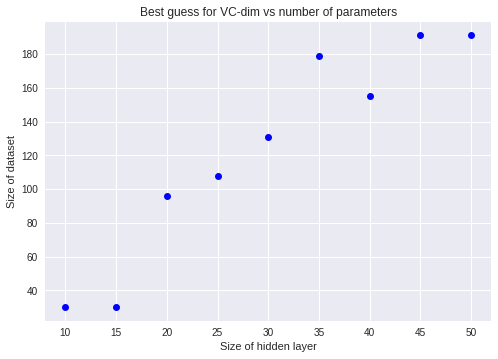

In [9]:
_,ax=plt.subplots()
ax.plot(network_sizes,fit_sizes.max(axis=1),'bo')
ax.set_xlabel('Size of hidden layer')
ax.set_ylabel('Size of dataset')
ax.set_title("Best guess for VC-dim vs number of parameters")
plt.savefig("neuralvc.png",dpi=300)
plt.show()

Yes, looks fairly linear! (Obviously, there is still a bit of noise in the data -- perhaps this should be run over night with more repeats, more network sizes.) Also it would be very interesting to see the effect of the depth, the number of layers, of the network.